In [1]:
import torch
from ultralytics import YOLO
from roboflow import Roboflow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import yaml
from IPython.display import Image, display

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
PATH = '/home/adip/workspaces/image_processing_ws/CubeDetection/'

In [4]:
# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n-obb.pt').to(device)


100%|██████████| 6.26M/6.26M [00:01<00:00, 4.04MB/s]


In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="9X8ClVkM9agUJAH3hcAN")
project = rf.workspace("hard-drive").project("cube-rzivb")
version = project.version(1)
dataset = version.download("yolov8-obb")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cube-1 in yolov8-obb:: 100%|██████████| 292/292 [00:00<00:00, 19441.50it/s]


In [7]:
# dataset.location = dataset.location + '/hard-drive-1'
print(dataset.location)

/home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1


Labels: ['1 0.4836754051308332 0.8480530517070516 0.44785536655826147 0.8371806559219586 0.4258243864274284 0.9097636057774071 0.46164442500000014 0.9206360015625001\n', '1 0.5339074137547283 0.8420359870789426 0.5091503223582358 0.7718653205235183 0.47319422735350747 0.7845510818820759 0.49795131875000004 0.8547217484375003\n', '1 0.4488616973685775 0.7240095662797046 0.40962710783238265 0.6489564657722322 0.3669532667474207 0.6712645466853531 0.40618785628361553 0.7463176471928255\n', '3 0.4236967184848379 0.5953966720556358 0.38925517620621486 0.5767482216452076 0.3559803749088769 0.6382029511520717 0.39042191718749997 0.6568514015625001\n', '3 0.438550486091402 0.9490906735830313 0.41952694112995703 0.8757866137312027 0.380461222226055 0.8859247760856717 0.3994847671875 0.9592288359375003\n', '3 0.37872838088049393 0.8977203055328038 0.34018063121439346 0.86346923060643 0.2925977706463995 0.9170211906986262 0.3311455203125 0.9512722656250002\n', '2 0.40667519784485895 0.77474886875

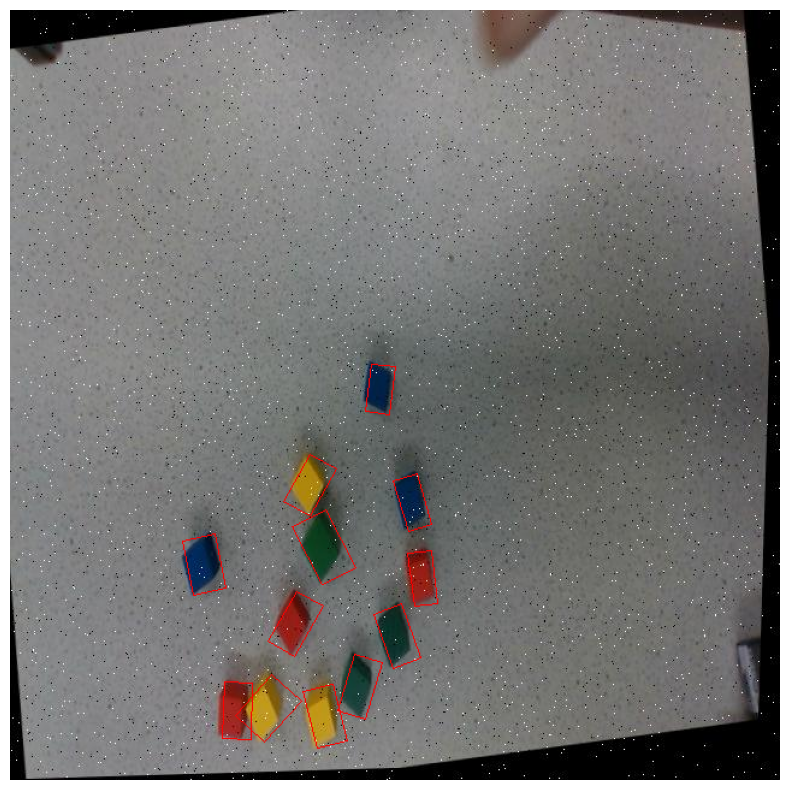

In [8]:

# Paths to train images and labels
train_images_path = os.path.join(dataset.location, 'train', 'images')
train_labels_path = os.path.join(dataset.location, 'train', 'labels')

# List all images in the train set
train_images = os.listdir(train_images_path)

# Select a random image
random_image = random.choice(train_images)
random_image_path = os.path.join(train_images_path, random_image)

# Read the image
image = cv2.imread(random_image_path)
height, width, _ = image.shape  # Get image dimensions
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the corresponding label
label_file = os.path.splitext(random_image)[0] + '.txt'
label_path = os.path.join(train_labels_path, label_file)

# Read label data
with open(label_path, 'r') as f:
    labels = f.readlines()

# Print labels for inspection
print("Labels:", labels)

# Draw bounding boxes and polygons
for label in labels:
    label = label.strip().split()
    class_id = int(label[0])  # Class ID
    coords = label[1:]  # The rest are coordinates

    # Convert normalized coordinates to pixel coordinates
    coords = [float(c) for c in coords]

    if len(coords) == 4:  # It's a bounding box
        # YOLO format: (center_x, center_y, width, height)
        center_x, center_y, box_width, box_height = coords

        # Convert from normalized to pixel values
        center_x = int(center_x * width)
        center_y = int(center_y * height)
        box_width = int(box_width * width)
        box_height = int(box_height * height)

        # Calculate the top-left and bottom-right points
        top_left_x = center_x - box_width // 2
        top_left_y = center_y - box_height // 2
        bottom_right_x = center_x + box_width // 2
        bottom_right_y = center_y + box_height // 2

        # Draw the bounding box
        cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color=(0, 255, 0), thickness=2)

    else:  # It's a polygon
        # Group the coordinates into pairs of (x, y)
        points = []
        for i in range(0, len(coords), 2):
            x = int(coords[i] * width)
            y = int(coords[i + 1] * height)
            points.append((x, y))

        # Convert list of points to a numpy array suitable for cv2.polylines
        pts = np.array(points, np.int32)
        pts = pts.reshape((-1, 1, 2))

        # Draw the polygon
        cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=1)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
sets = ['train', 'valid', 'test']
for set_name in sets:
    images_path = os.path.join(dataset.location, set_name, 'images')
    labels_path = os.path.join(dataset.location, set_name, 'labels')

    num_images = len(os.listdir(images_path))
    num_labels = len(os.listdir(labels_path))

    print(f"\n{set_name.capitalize()} set: {num_images} images, {num_labels} labels")

    # Count class instances
    class_counts = {}
    for label_file in os.listdir(labels_path):
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as f:
            labels = f.readlines()
            for label in labels:
                class_id = int(label.strip().split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    print(f"Class distribution in {set_name} set:")
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} instances")


Train set: 133 images, 133 labels
Class distribution in train set:
Class 3: 334 instances
Class 1: 335 instances
Class 2: 318 instances
Class 0: 348 instances

Valid set: 6 images, 6 labels
Class distribution in valid set:
Class 3: 14 instances
Class 2: 14 instances
Class 0: 13 instances
Class 1: 15 instances

Test set: 1 images, 1 labels
Class distribution in test set:
Class 3: 3 instances
Class 0: 3 instances
Class 2: 3 instances
Class 1: 3 instances


In [10]:
data_yaml_path = os.path.join(dataset.location, 'data.yaml')

In [11]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir /home/adip/workspaces/image_processing_ws/HardDrive/Screw/yoloV8/runs/large/train

In [13]:
save_dir = PATH + "Screw/yoloV8/runs/"
print(save_dir)

/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/


In [14]:
# Train the model
results = model.train(data=data_yaml_path, epochs=100, imgsz=640, device=device, project=save_dir, amp=False, batch=5)

Ultralytics 8.3.9 🚀 Python-3.10.15 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7940MiB)
engine/trainer: task=obb, mode=train, model=yolov8n-obb.pt, data=/home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/data.yaml, epochs=100, time=None, patience=100, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning /home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/train/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 2228.97it/s]

train: New cache created: /home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/valid/labels... 6 images, 1 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 1843.79it/s]

val: New cache created: /home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/valid/labels.cache


Plotting labels to /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 69 weight(decay=0.0), 79 weight(decay=0.0005078125), 78 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.54G      1.939      3.865      1.948         84        640: 100%|██████████| 27/27 [00:01<00:00, 16.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all          6         56     0.0265      0.609     0.0686     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       1.5G      1.555      3.441      1.674         42        640: 100%|██████████| 27/27 [00:01<00:00, 23.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 38.95it/s]

                   all          6         56     0.0314      0.929      0.138     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.49G      1.536      2.937      1.585         22        640: 100%|██████████| 27/27 [00:01<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 22.29it/s]

                   all          6         56     0.0304      0.964      0.211      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.49G      1.528      2.583      1.608         53        640: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.73it/s]

                   all          6         56      0.407      0.599      0.315      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.5G      1.482      2.272      1.563         54        640: 100%|██████████| 27/27 [00:01<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all          6         56      0.315      0.736      0.469      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       1.5G      1.487      2.125       1.54         67        640: 100%|██████████| 27/27 [00:01<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all          6         56      0.645      0.476      0.615      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       1.5G      1.457      1.964      1.492         80        640: 100%|██████████| 27/27 [00:01<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

                   all          6         56      0.553      0.742      0.756      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.5G      1.375      1.731      1.527         74        640: 100%|██████████| 27/27 [00:01<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

                   all          6         56      0.713      0.732      0.805      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       1.5G      1.394      1.666      1.487         39        640: 100%|██████████| 27/27 [00:01<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all          6         56       0.68      0.739      0.793      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.5G      1.403       1.58      1.527         69        640: 100%|██████████| 27/27 [00:01<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

                   all          6         56      0.617      0.875      0.809       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       1.5G      1.346      1.478      1.486         53        640: 100%|██████████| 27/27 [00:01<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all          6         56      0.696       0.92      0.848      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       1.5G      1.335      1.401      1.505         61        640: 100%|██████████| 27/27 [00:01<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all          6         56      0.747      0.946      0.852       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       1.5G      1.318      1.311      1.468         37        640: 100%|██████████| 27/27 [00:01<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all          6         56       0.78      0.982      0.886      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.49G      1.304      1.299      1.474         86        640: 100%|██████████| 27/27 [00:01<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all          6         56      0.766      0.989      0.871      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       1.5G      1.337      1.254      1.543         18        640: 100%|██████████| 27/27 [00:01<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all          6         56      0.774          1      0.882      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       1.5G      1.307      1.209      1.463         26        640: 100%|██████████| 27/27 [00:01<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all          6         56      0.762          1      0.905      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       1.5G      1.323      1.154      1.469         34        640: 100%|██████████| 27/27 [00:01<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all          6         56      0.786      0.998       0.88      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.49G      1.252      1.114      1.463         47        640: 100%|██████████| 27/27 [00:01<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all          6         56      0.778      0.992      0.845      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       1.5G      1.271      1.078       1.47         22        640: 100%|██████████| 27/27 [00:01<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]

                   all          6         56      0.804      0.974      0.863       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.5G      1.312      1.107      1.441         65        640: 100%|██████████| 27/27 [00:01<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.34it/s]

                   all          6         56      0.804      0.999      0.877      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       1.5G      1.253      1.074      1.474         33        640: 100%|██████████| 27/27 [00:01<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]

                   all          6         56      0.794          1      0.852      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       1.5G      1.264      1.065      1.456         27        640: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]

                   all          6         56      0.787      0.969      0.855      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.49G      1.235      1.033      1.442         27        640: 100%|██████████| 27/27 [00:01<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.67it/s]

                   all          6         56      0.776      0.994      0.834      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.49G      1.211      1.031      1.406         46        640: 100%|██████████| 27/27 [00:01<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.38it/s]

                   all          6         56      0.792          1      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       1.5G      1.158     0.9897      1.388         40        640: 100%|██████████| 27/27 [00:01<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]

                   all          6         56      0.787      0.996      0.874      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       1.5G      1.222     0.9738       1.45         23        640: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.90it/s]

                   all          6         56      0.804      0.994       0.89      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       1.5G      1.193     0.9553      1.453         34        640: 100%|██████████| 27/27 [00:01<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]

                   all          6         56      0.803          1        0.9       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       1.5G      1.196       1.01      1.438         81        640: 100%|██████████| 27/27 [00:01<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.71it/s]

                   all          6         56      0.793      0.987      0.877      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.49G      1.214     0.9924      1.436         42        640: 100%|██████████| 27/27 [00:01<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.16it/s]

                   all          6         56      0.773          1      0.895      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       1.5G      1.175      1.012       1.44         41        640: 100%|██████████| 27/27 [00:01<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.14it/s]

                   all          6         56      0.792      0.984      0.928      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.49G      1.222     0.9737      1.408         66        640: 100%|██████████| 27/27 [00:01<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


                   all          6         56       0.78          1      0.905      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       1.5G      1.143      0.935      1.397         50        640: 100%|██████████| 27/27 [00:01<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.68it/s]

                   all          6         56       0.79      0.983      0.882      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       1.5G      1.156     0.9354      1.409         56        640: 100%|██████████| 27/27 [00:01<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.13it/s]

                   all          6         56      0.792      0.998      0.872      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.5G      1.121     0.9101      1.385         47        640: 100%|██████████| 27/27 [00:01<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.59it/s]

                   all          6         56      0.791      0.999      0.874      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       1.5G      1.096     0.9107      1.398         38        640: 100%|██████████| 27/27 [00:01<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.42it/s]

                   all          6         56      0.777          1      0.864      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       1.5G      1.134     0.8939      1.416         47        640: 100%|██████████| 27/27 [00:01<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.38it/s]

                   all          6         56      0.778          1      0.885      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       1.5G      1.123     0.8959      1.415         19        640: 100%|██████████| 27/27 [00:01<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.16it/s]


                   all          6         56      0.796      0.984      0.891      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.49G        1.1     0.8694      1.366         38        640: 100%|██████████| 27/27 [00:01<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

                   all          6         56      0.795      0.993      0.888       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.49G      1.112     0.9265      1.425         37        640: 100%|██████████| 27/27 [00:01<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.65it/s]

                   all          6         56      0.788      0.978      0.886      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       1.5G      1.104     0.8693      1.386         44        640: 100%|██████████| 27/27 [00:01<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.21it/s]

                   all          6         56      0.781      0.992      0.896      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       1.5G      1.148     0.8904      1.397         37        640: 100%|██████████| 27/27 [00:01<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 21.69it/s]

                   all          6         56      0.793          1      0.902       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.49G       1.17     0.9169      1.404         33        640: 100%|██████████| 27/27 [00:01<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 23.39it/s]

                   all          6         56      0.786          1      0.894      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       1.5G      1.123       0.88      1.378         45        640: 100%|██████████| 27/27 [00:01<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 24.93it/s]

                   all          6         56       0.78      0.967      0.901      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       1.5G      1.134     0.8721      1.388         30        640: 100%|██████████| 27/27 [00:01<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 24.74it/s]

                   all          6         56      0.789      0.995      0.919      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       1.5G      1.149     0.8684      1.428         29        640: 100%|██████████| 27/27 [00:01<00:00, 23.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 25.91it/s]

                   all          6         56      0.799          1      0.918      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       1.5G      1.107     0.8723      1.322         25        640: 100%|██████████| 27/27 [00:01<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 28.62it/s]

                   all          6         56      0.801      0.994      0.909      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       1.5G      1.117     0.8654      1.368         28        640: 100%|██████████| 27/27 [00:01<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 29.17it/s]

                   all          6         56      0.806      0.981      0.882      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       1.5G      1.138     0.9006      1.354         48        640: 100%|██████████| 27/27 [00:01<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 31.76it/s]

                   all          6         56      0.803      0.991      0.896      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.49G      1.128     0.8545      1.368         56        640: 100%|██████████| 27/27 [00:01<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 24.32it/s]

                   all          6         56      0.793      0.992      0.904      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       1.5G      1.101     0.8486       1.31         68        640: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 35.85it/s]

                   all          6         56      0.803      0.984      0.906      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.49G      1.126     0.8454      1.361         80        640: 100%|██████████| 27/27 [00:01<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 39.05it/s]

                   all          6         56      0.806      0.991      0.901      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       1.5G      1.141       0.84      1.371         37        640: 100%|██████████| 27/27 [00:01<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 40.52it/s]

                   all          6         56      0.804      0.994      0.918      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       1.5G      1.084       0.84      1.368         36        640: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 40.23it/s]

                   all          6         56       0.81       0.98      0.926      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       1.5G      1.141     0.8523       1.39         31        640: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 39.84it/s]

                   all          6         56      0.797      0.992      0.909      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       1.5G       1.11     0.8483      1.357         37        640: 100%|██████████| 27/27 [00:01<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 46.24it/s]

                   all          6         56      0.789      0.995      0.904      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       1.5G      1.037     0.8178      1.323         38        640: 100%|██████████| 27/27 [00:01<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 46.56it/s]

                   all          6         56      0.792      0.989      0.918       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.49G      1.071      0.833      1.334         41        640: 100%|██████████| 27/27 [00:01<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 40.58it/s]

                   all          6         56      0.794      0.987      0.913       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       1.5G      1.073     0.8075      1.352         50        640: 100%|██████████| 27/27 [00:01<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 51.73it/s]

                   all          6         56      0.798      0.984      0.901      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       1.5G      1.058     0.8231      1.416         40        640: 100%|██████████| 27/27 [00:01<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 48.40it/s]

                   all          6         56      0.804       0.98      0.895      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       1.5G      1.138     0.8398      1.343         80        640: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 46.32it/s]

                   all          6         56        0.8      0.975      0.914      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       1.5G      1.114     0.8599      1.361         23        640: 100%|██████████| 27/27 [00:01<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.51it/s]

                   all          6         56      0.799      0.976      0.917      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       1.5G      1.102     0.8164       1.34         31        640: 100%|██████████| 27/27 [00:01<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 48.04it/s]

                   all          6         56      0.802      0.973      0.898      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.49G      1.101     0.8306      1.363         45        640: 100%|██████████| 27/27 [00:01<00:00, 22.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 49.19it/s]

                   all          6         56      0.799      0.995      0.913      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       1.5G      1.073     0.8487      1.362         63        640: 100%|██████████| 27/27 [00:01<00:00, 22.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 45.33it/s]

                   all          6         56      0.806      0.999      0.907      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       1.5G      1.092     0.8313      1.333         47        640: 100%|██████████| 27/27 [00:01<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 51.53it/s]

                   all          6         56      0.794      0.998      0.912      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.49G      1.055     0.8533      1.358         19        640: 100%|██████████| 27/27 [00:01<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 51.11it/s]


                   all          6         56      0.782       0.99      0.914      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       1.5G      1.095     0.8234      1.363         51        640: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 51.61it/s]

                   all          6         56      0.791      0.995      0.922      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       1.5G      1.066     0.8253      1.352         41        640: 100%|██████████| 27/27 [00:01<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 45.16it/s]

                   all          6         56      0.798      0.995      0.929      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       1.5G      1.099     0.8519      1.362         32        640: 100%|██████████| 27/27 [00:01<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.65it/s]

                   all          6         56      0.803      0.996      0.916       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       1.5G      1.062     0.8055       1.36         38        640: 100%|██████████| 27/27 [00:01<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 50.19it/s]

                   all          6         56      0.797      0.994      0.904      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.49G      1.052     0.7854      1.344         35        640: 100%|██████████| 27/27 [00:01<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 51.28it/s]

                   all          6         56      0.794      0.992      0.899      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       1.5G      1.079     0.8503      1.351         53        640: 100%|██████████| 27/27 [00:01<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 56.37it/s]

                   all          6         56      0.796      0.979      0.906      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       1.5G      1.044     0.8138       1.37         41        640: 100%|██████████| 27/27 [00:01<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 37.80it/s]

                   all          6         56        0.8       0.98      0.908      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.49G      1.082     0.7954      1.351         79        640: 100%|██████████| 27/27 [00:01<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.41it/s]

                   all          6         56      0.799      0.987       0.91      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.49G      1.073     0.8113      1.351         75        640: 100%|██████████| 27/27 [00:01<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 40.82it/s]

                   all          6         56        0.8      0.992      0.915      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.49G      1.054     0.7793      1.366         41        640: 100%|██████████| 27/27 [00:01<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.49it/s]

                   all          6         56      0.801      0.979      0.903      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.49G      1.044     0.8218      1.349         30        640: 100%|██████████| 27/27 [00:01<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 49.59it/s]


                   all          6         56      0.803      0.959      0.901      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.49G      1.037      0.792      1.339         35        640: 100%|██████████| 27/27 [00:01<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 44.08it/s]

                   all          6         56      0.805      0.954      0.887      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       1.5G      1.091     0.8179       1.37         20        640: 100%|██████████| 27/27 [00:01<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 56.70it/s]

                   all          6         56      0.793      0.986      0.883      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.49G      1.069     0.7919       1.33         65        640: 100%|██████████| 27/27 [00:01<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.58it/s]

                   all          6         56      0.798      0.985      0.894      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       1.5G       1.04     0.7814      1.345         66        640: 100%|██████████| 27/27 [00:01<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.48it/s]

                   all          6         56      0.804      0.984      0.907      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.51G      1.073     0.7828      1.371         33        640: 100%|██████████| 27/27 [00:01<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 49.30it/s]

                   all          6         56      0.801      0.985      0.916      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       1.5G       1.05      0.793      1.323         47        640: 100%|██████████| 27/27 [00:01<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.50it/s]

                   all          6         56      0.802      0.976      0.922      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       1.5G       1.05      0.792      1.306         47        640: 100%|██████████| 27/27 [00:01<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.09it/s]

                   all          6         56      0.802      0.943      0.912      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.49G      1.099     0.7942      1.394         36        640: 100%|██████████| 27/27 [00:01<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.84it/s]


                   all          6         56      0.794      0.931      0.905       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       1.5G      1.044     0.7763      1.328         44        640: 100%|██████████| 27/27 [00:01<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.64it/s]

                   all          6         56      0.792      0.924      0.894      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.49G      1.079     0.7856      1.355         20        640: 100%|██████████| 27/27 [00:01<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.51it/s]

                   all          6         56      0.793      0.927      0.901      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       1.5G      0.985     0.7444       1.33         32        640: 100%|██████████| 27/27 [00:01<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 50.84it/s]

                   all          6         56      0.803      0.945      0.907      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       1.5G      1.027     0.7584      1.323         22        640: 100%|██████████| 27/27 [00:01<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 49.75it/s]

                   all          6         56        0.8      0.975      0.919      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       1.5G      1.057     0.7919      1.318         90        640: 100%|██████████| 27/27 [00:01<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 56.97it/s]

                   all          6         56      0.801      0.966      0.921      0.784


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.49G      1.016      0.779      1.368         23        640: 100%|██████████| 27/27 [00:01<00:00, 19.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.36it/s]

                   all          6         56      0.798      0.964      0.919      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.49G      1.007     0.7484      1.339         36        640: 100%|██████████| 27/27 [00:01<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 53.80it/s]


                   all          6         56      0.797       0.94      0.916      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.49G      1.028     0.7525       1.36         29        640: 100%|██████████| 27/27 [00:01<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 55.31it/s]

                   all          6         56      0.796       0.94      0.923      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.48G       1.01      0.772      1.333         35        640: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 49.47it/s]

                   all          6         56      0.796      0.938      0.923      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.49G      1.012     0.7654      1.329         26        640: 100%|██████████| 27/27 [00:01<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 54.80it/s]

                   all          6         56      0.799      0.939      0.928      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.49G      1.012     0.7457      1.317         34        640: 100%|██████████| 27/27 [00:01<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 50.69it/s]


                   all          6         56      0.801       0.94      0.928      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.48G      1.011     0.7643      1.317         22        640: 100%|██████████| 27/27 [00:01<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 55.23it/s]

                   all          6         56      0.801      0.941      0.931      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.49G      1.003     0.7621      1.346         32        640: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 55.68it/s]

                   all          6         56      0.801      0.959      0.929      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.48G     0.9802     0.7301      1.299         25        640: 100%|██████████| 27/27 [00:01<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 57.42it/s]

                   all          6         56      0.803      0.942       0.93      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.49G     0.9837     0.7482      1.339         19        640: 100%|██████████| 27/27 [00:01<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 55.24it/s]

                   all          6         56      0.803      0.942      0.927        0.8



100 epochs completed in 0.042 hours.
Optimizer stripped from /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/last.pt, 5.8MB
Optimizer stripped from /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt, 5.8MB

Validating /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt...
Ultralytics 8.3.9 🚀 Python-3.10.15 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7940MiB)
YOLOv8n-obb summary (fused): 205 layers, 2,756,719 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 45.77it/s]


                   all          6         56      0.801      0.941      0.931      0.804
             blue_cube          5         13      0.809          1       0.92      0.838
            green_cube          5         15      0.806      0.835      0.933      0.825
              red_cube          5         14      0.805      0.929      0.903      0.739
           yellow_cube          5         14      0.783          1      0.967      0.813
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train


In [15]:
print("Precision: ",results.results_dict['metrics/precision(B)'])
print("Recall: ",results.results_dict['metrics/recall(B)'])
print("mAP50: ",results.results_dict['metrics/mAP50(B)'])
print("mAP50-95: ",results.results_dict['metrics/mAP50-95(B)'])
print("fitness: ",results.results_dict['fitness'])

Precision:  0.801036093387602
Recall:  0.940804618868801
mAP50:  0.9306165518133397
mAP50-95:  0.803951715850489
fitness:  0.816618199446774


In [16]:
# Display confusion matrix for validation set with a smaller size
confusion_matrix_path = 'runs/train/confusion_matrix.png'
if os.path.exists(confusion_matrix_path):
    from IPython.display import Image, display
    display(Image(filename=confusion_matrix_path, width=800))  # Adjust width as needed
else:
    print("Confusion matrix image not found.")


Confusion matrix image not found.


In [17]:
trained_model_path = PATH + 'Screw/yoloV8/runs/train/weights/best.pt' 
trained_model = YOLO(trained_model_path).to(device)


image 1/1 /home/adip/workspaces/image_processing_ws/CubeDetection/yoloV8/Cube-1/test/images/image_7_png.rf.dec5a2240b6fe3a83f303c2cfd839168.jpg: 640x640 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


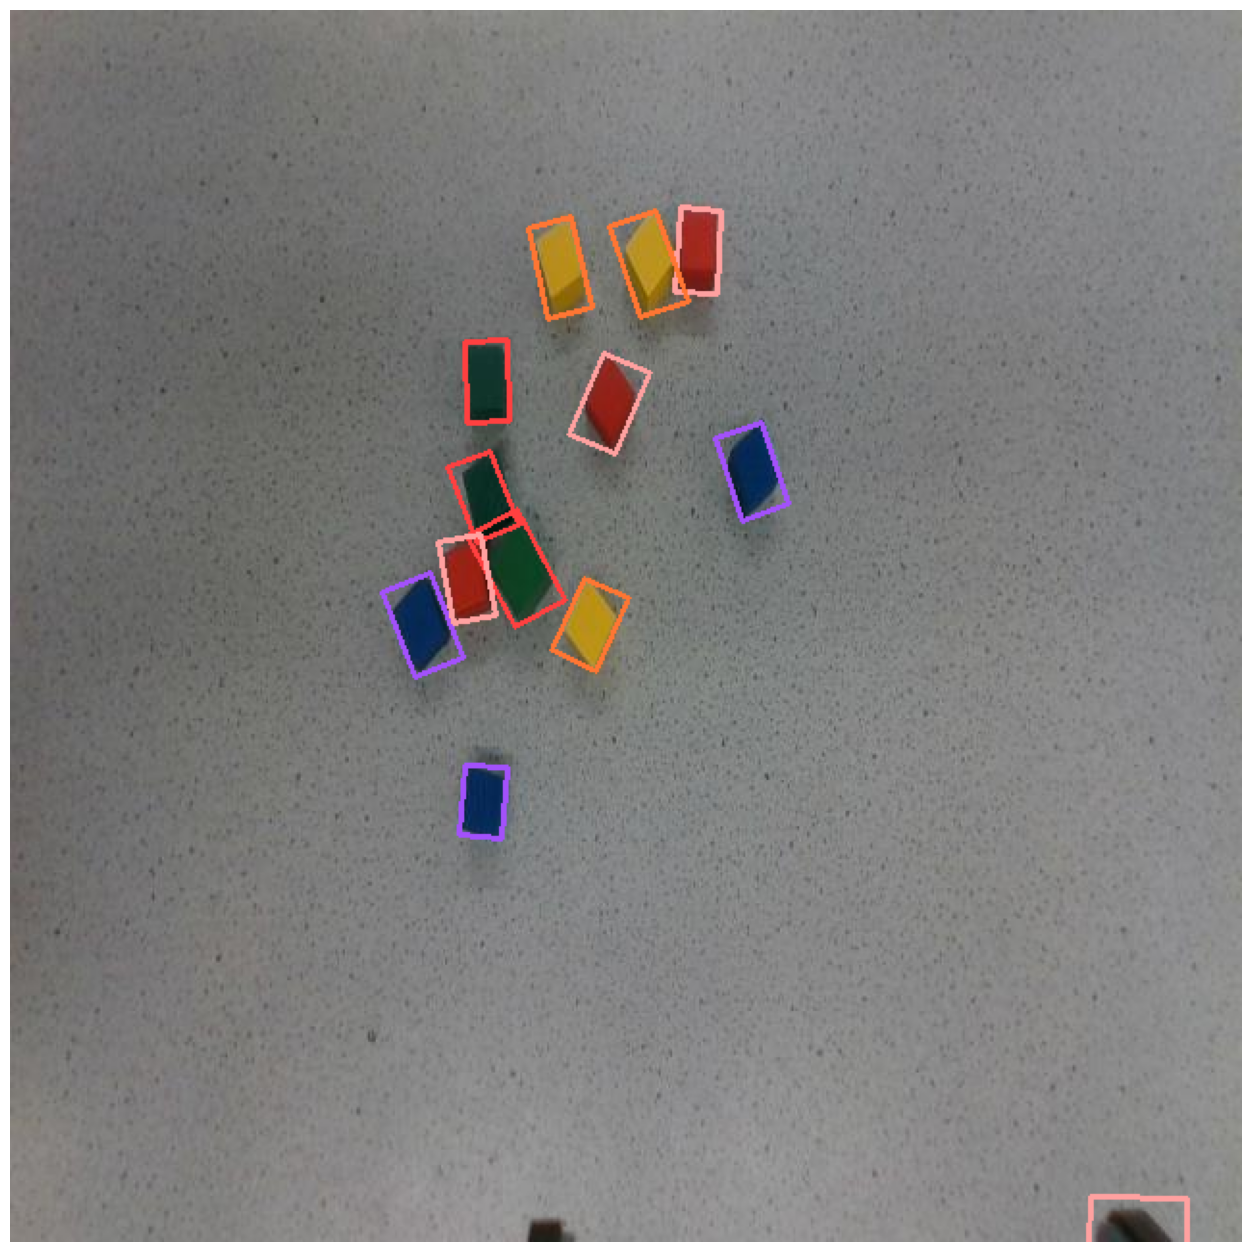

In [19]:
model = YOLO('/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

import supervision as sv
import cv2

detections = sv.Detections.from_ultralytics(results[0])

oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=cv2.imread(file_name),
    detections=detections
)

sv.plot_image(image=annotated_frame, size=(16, 16))

In [20]:
import cv2

def list_available_cameras():
    available_cameras = []

    for index in range(10):  # You can change the range if you expect more than 10 cameras.
        cap = cv2.VideoCapture(index)
        if cap.isOpened():
            available_cameras.append(index)
            cap.release()  # Release the camera once checked
            
    return available_cameras

# Get the list of available cameras
cameras = list_available_cameras()

if cameras:
    print(f"Available cameras found at indices: {cameras}")
else:
    print("No cameras found.")

Available cameras found at indices: [0, 2, 6, 8]


[ WARN:0@583.853] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@583.932] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@583.943] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ERROR:0@583.944] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@583.949] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video4): can't open camera by index
[ERROR:0@583.950] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@583.950] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video5): can't open camera by index
[ERROR:0@583.951] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
[ WARN:0@583.953] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video7): can't open camera by index
[ERROR:0@583.954] global obsensor_uvc_stream_channel.cpp:158 get

In [21]:
from ultralytics import YOLO  # Ensure you have the correct YOLO library
import supervision as sv
import cv2

# Load your trained YOLO model
model = YOLO('/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt')

# Open a connection to webcam 8
cap = cv2.VideoCapture(8)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam 8.")
    exit()

# Initialize the OrientedBoxAnnotator
oriented_box_annotator = sv.OrientedBoxAnnotator()

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to read frame from webcam.")
        break

    # Run the YOLO model on the frame
    results = model(frame)

    # Convert model results to detections
    detections = sv.Detections.from_ultralytics(results[0])

    # Annotate the frame with detections
    annotated_frame = oriented_box_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Display the annotated frame
    cv2.imshow('YOLO Real-Time Detection', annotated_frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 32.7ms
Speed: 0.5ms preprocess, 32.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 2.9ms
Speed: 0.7ms preprocess, 2.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.0ms
Speed: 0.9ms preprocess, 3.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.7ms
Speed: 0.6ms preprocess, 2.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.9ms
Speed: 0.7ms preprocess, 2.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.9ms
Speed: 0.7ms preprocess, 2.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.7ms
Speed: 0.7ms preprocess, 2.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.7ms
Speed: 0.8ms preprocess, 2.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3.0ms
Speed: 0.7ms prep

In [1]:
from ultralytics import YOLO  # Ensure you have the correct YOLO library
import supervision as sv
import cv2
import numpy as np

# Load your trained YOLO model
model = YOLO('/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt')

# Open a connection to webcam 8
cap = cv2.VideoCapture(8)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam 8.")
    exit()

# Initialize the OrientedBoxAnnotator
oriented_box_annotator = sv.OrientedBoxAnnotator()

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to read frame from webcam.")
        break

    # Run the YOLO model on the frame
    results = model(frame)

    # Convert model results to detections
    detections = sv.Detections.from_ultralytics(results[0])

    # Annotate the frame with detections
    annotated_frame = oriented_box_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]

    # Now, for each detection, compute centroid and orientation
    for i in range(len(detections)):
        # Get the bounding box coordinates
        bbox = detections.xyxy[i]  # bbox is [xmin, ymin, xmax, ymax]

        # Convert coordinates to integers
        xmin, ymin, xmax, ymax = bbox.astype(int)

        # Clip coordinates to be within the frame dimensions
        xmin = max(0, min(xmin, frame_width - 1))
        xmax = max(0, min(xmax, frame_width - 1))
        ymin = max(0, min(ymin, frame_height - 1))
        ymax = max(0, min(ymax, frame_height - 1))

        # Ensure that the coordinates are valid
        if xmax <= xmin or ymax <= ymin:
            continue  # Skip invalid bounding boxes

        # Extract ROI from frame
        roi = frame[ymin:ymax, xmin:xmax]

        # Check if ROI is not empty
        if roi.size == 0:
            continue  # Skip if ROI is empty

        # Convert ROI to grayscale
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Apply thresholding
        _, thresh = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)

            # Get minimum area rectangle
            rect = cv2.minAreaRect(largest_contour)

            # rect contains ((x_center, y_center), (width, height), angle of rotation)

            # Get the centroid and angle
            (x_center_roi, y_center_roi), (width, height), angle = rect

            # Adjust the center coordinates relative to the original frame
            x_center = int(x_center_roi + xmin)
            y_center = int(y_center_roi + ymin)

            # Draw centroid on the annotated frame
            cv2.circle(annotated_frame, (x_center, y_center), 5, (0, 255, 0), -1)

            # Get box points and adjust coordinates
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            box[:, 0] += xmin  # Adjust x coordinates
            box[:, 1] += ymin  # Adjust y coordinates

            # Draw the rotated rectangle on the annotated frame
            cv2.drawContours(annotated_frame, [box], 0, (0, 0, 255), 2)

            # Overlay centroid coordinates and orientation angle
            label = f"({x_center}, {y_center}), Angle: {angle:.2f}°"
            cv2.putText(annotated_frame, label, (x_center + 10, y_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        else:
            # If no contours are found, compute centroid from bounding box
            x_center = int((xmin + xmax) / 2)
            y_center = int((ymin + ymax) / 2)
            cv2.circle(annotated_frame, (x_center, y_center), 5, (0, 255, 0), -1)
            label = f"({x_center}, {y_center}), Angle: N/A"
            cv2.putText(annotated_frame, label, (x_center + 10, y_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Display the annotated frame
    cv2.imshow('YOLO Real-Time Detection', annotated_frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 30.2ms
Speed: 0.8ms preprocess, 30.2ms inference, 18.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 2.6ms
Speed: 1.0ms preprocess, 2.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.5ms
Speed: 0.8ms preprocess, 2.5ms inference, 40.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.3ms
Speed: 0.6ms preprocess, 2.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.5ms
Speed: 0.7ms preprocess, 2.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.4ms
Speed: 0.6ms preprocess, 2.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.5ms
Speed: 0.7ms preprocess, 2.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2.5ms
Speed: 0.8ms pr

In [1]:
from ultralytics import YOLO  # Ensure you have the correct YOLO library
import supervision as sv
import cv2
import numpy as np

# Load your trained YOLO model
model = YOLO('/home/adip/workspaces/image_processing_ws/CubeDetection/Screw/yoloV8/runs/train/weights/best.pt')

# Open a connection to webcam 8
cap = cv2.VideoCapture(8)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam 8.")
    exit()

# Initialize the OrientedBoxAnnotator
oriented_box_annotator = sv.OrientedBoxAnnotator()

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to read frame from webcam.")
        break

    # Run the YOLO model on the frame
    results = model(frame)

    # Convert model results to detections
    detections = sv.Detections.from_ultralytics(results[0])

    # Annotate the frame with detections
    annotated_frame = oriented_box_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]

    # Now, for each detection, compute centroid and orientation axes
    for i in range(len(detections)):
        # Get the bounding box coordinates
        bbox = detections.xyxy[i]  # bbox is [xmin, ymin, xmax, ymax]

        # Convert coordinates to integers
        xmin, ymin, xmax, ymax = bbox.astype(int)

        # Clip coordinates to be within the frame dimensions
        xmin = max(0, min(xmin, frame_width - 1))
        xmax = max(0, min(xmax, frame_width - 1))
        ymin = max(0, min(ymin, frame_height - 1))
        ymax = max(0, min(ymax, frame_height - 1))

        # Ensure that the coordinates are valid
        if xmax <= xmin or ymax <= ymin:
            continue  # Skip invalid bounding boxes

        # Extract ROI from frame
        roi = frame[ymin:ymax, xmin:xmax]

        # Check if ROI is not empty
        if roi.size == 0:
            continue  # Skip if ROI is empty

        # Convert ROI to grayscale
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Apply thresholding
        _, thresh = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)

            # Get minimum area rectangle
            rect = cv2.minAreaRect(largest_contour)

            # rect contains ((x_center, y_center), (width, height), angle of rotation)

            # Get the centroid and angle
            (x_center_roi, y_center_roi), (width, height), angle = rect

            # Convert angle to radians
            angle_rad = np.deg2rad(angle)

            # Ensure width and height are not zero
            if width == 0 or height == 0:
                continue

            # Direction vector along width (x-axis)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            # Start and end points for width axis
            start_point_width = (x_center_roi - dx * width / 2, y_center_roi - dy * width / 2)
            end_point_width = (x_center_roi + dx * width / 2, y_center_roi + dy * width / 2)

            # Direction vector along height (y-axis)
            dx_h = -np.sin(angle_rad)
            dy_h = np.cos(angle_rad)

            # Start and end points for height axis
            start_point_height = (x_center_roi - dx_h * height / 2, y_center_roi - dy_h * height / 2)
            end_point_height = (x_center_roi + dx_h * height / 2, y_center_roi + dy_h * height / 2)

            # Adjust to original frame coordinates
            x_center = int(x_center_roi + xmin)
            y_center = int(y_center_roi + ymin)

            start_point_width = (int(start_point_width[0] + xmin), int(start_point_width[1] + ymin))
            end_point_width = (int(end_point_width[0] + xmin), int(end_point_width[1] + ymin))

            start_point_height = (int(start_point_height[0] + xmin), int(start_point_height[1] + ymin))
            end_point_height = (int(end_point_height[0] + xmin), int(end_point_height[1] + ymin))

            # Draw centroid on the annotated frame
            cv2.circle(annotated_frame, (x_center, y_center), 5, (0, 0, 255), -1)

            # Draw the orientation axes
            # Draw the x-axis (width axis) in blue
            cv2.line(annotated_frame, start_point_width, end_point_width, (255, 0, 0), 2)

            # Draw the y-axis (height axis) in green
            cv2.line(annotated_frame, start_point_height, end_point_height, (0, 255, 0), 2)

            # Overlay centroid coordinates and orientation angle
            label = f"({x_center}, {y_center}), Angle: {angle:.2f}°"
            cv2.putText(annotated_frame, label, (x_center + 10, y_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        else:
            # If no contours are found, compute centroid from bounding box
            x_center = int((xmin + xmax) / 2)
            y_center = int((ymin + ymax) / 2)
            cv2.circle(annotated_frame, (x_center, y_center), 5, (0, 0, 255), -1)
            label = f"({x_center}, {y_center}), Angle: N/A"
            cv2.putText(annotated_frame, label, (x_center + 10, y_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Display the annotated frame
    cv2.imshow('YOLO Real-Time Detection', annotated_frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 29.9ms
Speed: 0.9ms preprocess, 29.9ms inference, 8.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.1ms
Speed: 1.4ms preprocess, 3.1ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.7ms
Speed: 1.3ms preprocess, 3.7ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.0ms
Speed: 0.9ms preprocess, 3.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.2ms
Speed: 0.9ms preprocess, 3.2ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.5ms
Speed: 0.9ms preprocess, 3.5ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 3.1ms
Speed: 0.8ms preprocess, 3.1ms inference, 0.3m